# Credit Card Approval Machine

Commercial bank recieves lots of credit card application every day. If each application is done by hand by hand, there are several cons:
#### **1. Human check may have risk for missing check or making mistake.**
#### **2. It is not efficient for the staff to check lots of data**

As a result, creating a program that it can be a assisstant for operator to check each application and make a right decision. Here is the pros:
#### **1. The program can have high accuracy and precision rate to classify qualified & dis-qualified**
#### **2. It can enhance the staff's working efficiency.**

# Start creating a machine

## Here are the steps:
1. Check datatype, missing values
2. Convert the **missing values as mean or mode**
3. Make the catrgorical variables as **dummies**
4. Do the **Standardization** or **Normalization** to make sure there are no data bias impact.
5. Do the **GridSearchCV** or **RandomizedSearchCV** to find the **best hyper-parameters**
6. Do the **Cross-validation** to find the best performace of machine learning model.
7. Draw the confusion matrix and ROC, AUC.
8. Summary

In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble
from sklearn import svm
from collections import defaultdict

In [3]:
# Import pandas
import pandas as pd

# Load the dataset and need to be carefule that first row is not the column name.
column_name = [f'A{i}' for i in range(1,17)]
data = pd.read_csv('crx.data', header = None, names = column_name) 
print(data)

print(data.head())
print(data.info())

# Follwoing the dataset description, column 15th is the target variale.
y = data.pop('A16')
print(y)

    A1     A2      A3 A4 A5  A6  A7    A8 A9 A10  A11 A12 A13    A14  A15 A16
0    b  30.83   0.000  u  g   w   v  1.25  t   t    1   f   g  00202    0   +
1    a  58.67   4.460  u  g   q   h  3.04  t   t    6   f   g  00043  560   +
2    a  24.50   0.500  u  g   q   h  1.50  t   f    0   f   g  00280  824   +
3    b  27.83   1.540  u  g   w   v  3.75  t   t    5   t   g  00100    3   +
4    b  20.17   5.625  u  g   w   v  1.71  t   f    0   f   s  00120    0   +
..  ..    ...     ... .. ..  ..  ..   ... ..  ..  ...  ..  ..    ...  ...  ..
685  b  21.08  10.085  y  p   e   h  1.25  f   f    0   f   g  00260    0   -
686  a  22.67   0.750  u  g   c   v  2.00  f   t    2   t   g  00200  394   -
687  a  25.25  13.500  y  p  ff  ff  2.00  f   t    1   t   g  00200    1   -
688  b  17.92   0.205  u  g  aa   v  0.04  f   f    0   f   g  00280  750   -
689  b  35.00   3.375  u  g   c   h  8.29  f   f    0   t   g  00000    0   -

[690 rows x 16 columns]
  A1     A2     A3 A4 A5 A6 A7    A8 A9

##  Check if there is missing values

In [4]:
# Check the qualitative data if there are missing value.
qualitative_columns = ['A1','A2', 'A4','A5','A6','A7','A9','A10','A12','A13', 'A14']  # Specify the column names containing qualitative data
data_qualitative = data[qualitative_columns]
for column in qualitative_columns:
    print(data_qualitative[column].value_counts())
    print('-'*50)

# Switch the missing value '?' be an NaN
data = data.replace('?', np.NaN)

# Switch the 'A2' column as continuos variable & drop 'A14'
data['A2'] = data['A2'].astype(float)
data.pop('A14')
print(data.info())
print('-'*100)
print(y.value_counts())

b    468
a    210
?     12
Name: A1, dtype: int64
--------------------------------------------------
?        12
22.67     9
20.42     7
18.83     6
24.50     6
         ..
48.25     1
28.33     1
18.75     1
18.50     1
36.42     1
Name: A2, Length: 350, dtype: int64
--------------------------------------------------
u    519
y    163
?      6
l      2
Name: A4, dtype: int64
--------------------------------------------------
g     519
p     163
?       6
gg      2
Name: A5, dtype: int64
--------------------------------------------------
c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
d      30
e      25
j      10
?       9
r       3
Name: A6, dtype: int64
--------------------------------------------------
v     399
h     138
bb     59
ff     57
?       9
j       8
z       8
dd      6
n       4
o       2
Name: A7, dtype: int64
--------------------------------------------------
t    361
f    329
Name: A9, dtype: int64
-----------------

## Split the data to X_train, X_val,  y_train, y_val

In [5]:
# Split the data to training & testing dataset
X_train, X_val, y_train, y_val = model_selection.train_test_split(data, y, test_size = 0.3, random_state = 42)
print(X_train)
print(X_val)

    A1     A2      A3   A4   A5   A6   A7      A8 A9 A10  A11 A12 A13   A15
178  a  18.42   9.250    u    g    q    v   1.210  t   t    4   f   g   540
265  b  17.08   0.085    y    p    c    v   0.040  f   f    0   f   g   722
352  b  22.50  11.500    y    p    m    v   1.500  f   f    0   t   g  4000
529  b  43.25  25.210    u    g    q    h   0.210  t   t    1   f   g    90
409  b  17.08   0.250    u    g    q    v   0.335  f   t    4   f   g     8
..  ..    ...     ...  ...  ...  ...  ...     ... ..  ..  ...  ..  ..   ...
71   b  34.83   4.000    u    g    d   bb  12.500  t   f    0   t   g     0
106  b  28.75   1.165    u    g    k    v   0.500  t   f    0   f   s     0
270  b  37.58   0.000  NaN  NaN  NaN  NaN   0.000  f   f    0   f   p     0
435  b  19.00   0.000    y    p   ff   ff   0.000  f   t    4   f   g     1
102  b  18.67   5.000    u    g    q    v   0.375  t   t    2   f   g    38

[483 rows x 14 columns]
      A1     A2     A3 A4 A5   A6   A7     A8 A9 A10  A11 A12 A

## Replace the NaN as mean or mode

In [6]:
# Impute the missing values with mean imputation for quantitative data
X_train.fillna(X_train.mean(), inplace = True)
X_val.fillna(X_train.mean())

# Impute the missing values with mode imputation for qualitative data
for col in X_train.columns:
    if X_train[col].dtypes == 'object':
        X_train = X_train.fillna(X_train[col].value_counts().index[0])
print(X_train.isnull().sum())



for col in X_val.columns:
    if X_val[col].dtypes == 'object':
        X_val = X_val.fillna(X_train[col].value_counts().index[0])
print(X_val.isnull().sum())

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A15    0
dtype: int64
A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A15    0
dtype: int64


/var/folders/1h/xd7jgtrn02x5wg9csn4z01j40000gn/T/ipykernel_1719/76087973.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_train.fillna(X_train.mean(), inplace = True)
/var/folders/1h/xd7jgtrn02x5wg9csn4z01j40000gn/T/ipykernel_1719/76087973.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_val.fillna(X_train.mean())


## Convert the catgory variables into continuous variables

In [7]:
X_train = pd.get_dummies(X_train, drop_first = True) # Get K-1 dummy out of K categorical levels by removing first level.
X_val = pd.get_dummies(X_val, drop_first = True)
print(X_val)
print('-'*100)
print(X_val)
X_val = X_val.reindex(columns= X_train.columns, fill_value=0)

        A3     A8  A11   A15  A1_b  A2_15.75  A2_16.0  A2_16.08  A2_16.17  \
286  1.500  0.000    2   105     0         0        0         0         0   
511  4.000  0.000    0   960     0         0        0         0         0   
257  0.000  0.500    0     0     1         0        0         0         0   
336  6.500  1.000    0   228     1         0        0         0         0   
318  0.000  0.000    0     1     1         0        0         0         0   
..     ...    ...  ...   ...   ...       ...      ...       ...       ...   
601  1.750  0.000    0     1     1         0        0         0         0   
66   1.000  2.000   11   456     0         0        0         0         0   
11   1.835  4.335    0   200     1         0        0         0         0   
674  2.500  0.210    0   246     0         0        0         0         0   
559  2.290  2.290    7  2384     0         0        0         0         0   

     A2_16.25  ...  A7_h  A7_j  A7_n  A7_v  A7_z  A9_t  A10_t  A12_t  A13_p

In [8]:
# Do the Standardization or Normalization.
standardizer = preprocessing.StandardScaler()
X_train_scaled = standardizer.fit_transform(X_train)
X_val_scaled = standardizer.transform(X_val)

## Since this is binary classification problem, I choose these models:

1. Logistic Regression
2. Random forest
3. SVM
4. Bagging
5. XGBoost

In [9]:
# K-fold
kf = model_selection.KFold(n_splits = 4, shuffle = True, random_state = 42)

# Logistic Regression
param_grid = {'C': np.arange(0.001,1)}
logreg = linear_model.LogisticRegression()
logreg_cv = model_selection.GridSearchCV(logreg, param_grid = param_grid, cv = kf)
logreg_cv.fit(X_train_scaled, y_train)
print(f'Logistic Regression: {logreg_cv.best_params_}')
print(f'Logistic Regression: {logreg_cv.best_score_}')

# Random_forest
param_grid = {'max_depth': np.arange(5,20,1),'min_samples_leaf': np.arange(10,40,1)}
random_forest = ensemble.RandomForestClassifier()
random_forest_cv = model_selection.GridSearchCV(random_forest, param_grid = param_grid, cv = kf)
random_forest_cv.fit(X_train_scaled, y_train)
print(f'Random Forest: {random_forest_cv.best_params_}')
print(f'Random Forest: {random_forest_cv.best_score_}')

# SVM
param_grid= {'kernel': ['linear', 'poly', 'rbf'], 'C': np.linspace(0.1,30)}
svm_classifier = svm.SVC()
svm_classifier_cv = model_selection.GridSearchCV(svm_classifier, param_grid = param_grid, cv=kf)
svm_classifier_cv.fit(X_train_scaled, y_train)
print(f'SVC: {svm_classifier_cv.best_params_}')
print(f'SVC: {svm_classifier_cv.best_score_}')

# Bagging
param_grid = {'base_estimator__max_depth': np.arange(5, 20,1),'base_estimator__min_samples_leaf': np.arange(10, 40,1)}
bagging = ensemble.BaggingClassifier(base_estimator=ensemble.RandomForestClassifier())
bagging_cv = model_selection.GridSearchCV(bagging, param_grid=param_grid, cv = kf)
bagging_cv.fit(X_train_scaled, y_train)
print(f'Bagging : {bagging_cv.best_params_}')
print(f'Bagging : {bagging_cv.best_score_}')


Logistic Regression: {'C': 0.001}
Logistic Regression: 0.7639290633608816
Random Forest: {'max_depth': 12, 'min_samples_leaf': 14}
Random Forest: 0.8799242424242424
SVC: {'C': 1.3204081632653062, 'kernel': 'linear'}
SVC: 0.8509986225895317


/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging : {'base_estimator__max_depth': 13, 'base_estimator__min_samples_leaf': 14}
Bagging : 0.8778409090909091


/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[array([0.82644628, 0.76859504, 0.71900826, 0.74166667]), array([0.90909091, 0.88429752, 0.81818182, 0.86666667]), array([0.88429752, 0.82644628, 0.80991736, 0.88333333]), array([0.90082645, 0.85950413, 0.84297521, 0.86666667])]


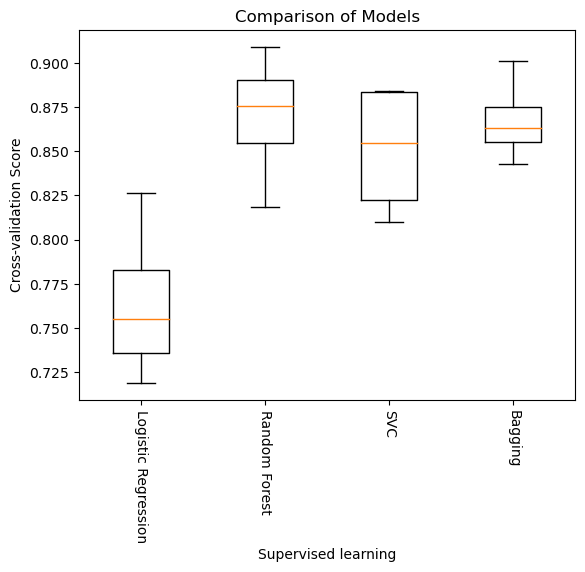

In [10]:
# Cross-Validation
models = {'Logistic Regression': linear_model.LogisticRegression(C = 0.001), 'Random Forest': ensemble.RandomForestClassifier(max_depth = 10,min_samples_leaf = 15),
          'SVC': svm.SVC(C = 1.3204, kernel = 'linear'),'Bagging': ensemble.BaggingClassifier(base_estimator=ensemble.RandomForestClassifier(max_depth = 14, min_samples_leaf = 10), n_estimators = 100)}
result = []
for model in models.values():
    cv_results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv = kf)
    result.append(cv_results)
print(result)


plt.boxplot(result, labels= models.keys())
plt.xlabel('Supervised learning')
plt.ylabel('Cross-validation Score')
plt.title('Comparison of Models')
plt.xticks(rotation = 270)
plt.show()

## Run the validation dataset
### - Get the output:
1. ACC for each model
2. Confusion_matrix for each model
3. classification_report for each model
==> Summarize the **Precision** & **Sensitivity (Recall)**

In [16]:
for name, model in models.items():
    classifier = model.fit(X_train_scaled, y_train)
    # Print val dataset ACC/ Check the mean accuracy 
    val_acc = classifier.score(X_val_scaled, y_val)
    print("{} Test Set Acc: {}".format(name, val_acc))
    # Print the confusion matrix
    y_val_pred = classifier.predict(X_val_scaled)
    print(metrics.confusion_matrix(y_val, y_val_pred))
    # Print the classification_report
    print(metrics.classification_report(y_val, y_val_pred)) # confusion_matrix(y_true, y_pred)
    print('='*100)
    
    

Logistic Regression Test Set Acc: 0.6811594202898551
[[ 32  65]
 [  1 109]]
              precision    recall  f1-score   support

           +       0.97      0.33      0.49        97
           -       0.63      0.99      0.77       110

    accuracy                           0.68       207
   macro avg       0.80      0.66      0.63       207
weighted avg       0.79      0.68      0.64       207

Random Forest Test Set Acc: 0.8502415458937198
[[ 75  22]
 [  9 101]]
              precision    recall  f1-score   support

           +       0.89      0.77      0.83        97
           -       0.82      0.92      0.87       110

    accuracy                           0.85       207
   macro avg       0.86      0.85      0.85       207
weighted avg       0.85      0.85      0.85       207

SVC Test Set Acc: 0.8357487922705314
[[87 10]
 [24 86]]
              precision    recall  f1-score   support

           +       0.78      0.90      0.84        97
           -       0.90      0.78  

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Test Set Acc: 0.855072463768116
[[ 76  21]
 [  9 101]]
              precision    recall  f1-score   support

           +       0.89      0.78      0.84        97
           -       0.83      0.92      0.87       110

    accuracy                           0.86       207
   macro avg       0.86      0.85      0.85       207
weighted avg       0.86      0.86      0.85       207



In [ ]:
print(result)
print('-'*100)
all_values = list(result.values())
print(all_values)
print(np.mean(all_values))

# ----------------------------------------------------------------------

In [ ]:
# Visualize the qualitative columns
# fig, ax = plt.subplots(2,5)
# for column in qualitative_columns:
#     plt.figure(figsize=(10, 6))
#     sns.countplot(data=data, x=column)
#     plt.xlabel(column)
#     plt.ylabel('Count')
#     plt.title(f'Count of {column}')
#     plt.xticks(rotation=45)
#     plt.show()